# Heart Rate Analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/main/docs/src/tutorials/heart_rate_analysis.ipynb)

In this notebook, we will explore how to use Temporian to load, visualize, and process medical data. Our main goal is to create a Temporian program that can detect heartbeats and calculate both the heart rate and heart rate variability from raw [ECG](https://en.wikipedia.org/wiki/Electrocardiography) signals.

To do this, we will use the ECG and respiratory waveforms data of three patients from the [Apnea-ECG](https://www.physionet.org/content/apnea-ecg/1.0.0/) vital sign dataset, which is available on the [PhysioNet](https://physionet.org/) repository. We will load this data into Temporian using the [WFDB](https://wfdb.readthedocs.io/en/latest/) python package, which is a widely used tool for working with physiological signals.

## Install and import dependencies

In [ ]:
# Skip this cell if you are running the notebook locally and have already installed temporian.
%pip install temporian

In [ ]:
# wfdb: Load data from PhysioNet.
%pip install wfdb -q

# bokeh: Use by Temporian for interactive plotting.
# If bokeh is not installed, only static plotting is available.
%pip install bokeh -q

In [1]:
import temporian as tp

import os
import wfdb
import pandas as pd
import numpy as np

## Download patient data

We download the data of the patients `a1-3`. The records `a1-3`contain the ECG, while the records `a1-3r` contain the respiratory signals.

In [2]:
patients = ["a01", "a02", "a03"]

tmp_directory = "tmp_vital_signs"
if not os.path.isdir(tmp_directory):
    wfdb.dl_database(
        "apnea-ecg",
        dl_dir=tmp_directory,
        records=patients + [f"{p}r" for p in patients],
    )

## Convert patient data to PhysioNet to Temporian format

We convert the PhysioNet data into Temporian data. The ECG and respiratory records are exported into two event sets `ecg_data` and `resp_data`.

In [3]:
def load_patient(patient: list[str]) -> tuple:
    """Returns the ECG and Respiratory signals"""
    signals_ecg, fields_ecg = wfdb.rdsamp(f"{tmp_directory}/{patient}")
    signals_resp, fields_resp = wfdb.rdsamp(f"{tmp_directory}/{patient}r")

    # TODO: Skip DataFrame conversion.
    df_ecg = pd.DataFrame(signals_ecg, columns=fields_ecg["sig_name"])
    df_resp = pd.DataFrame(signals_resp, columns=fields_resp["sig_name"])

    df_ecg["timestamp"] = np.arange(fields_ecg["sig_len"]) / fields_ecg["fs"]
    df_resp["timestamp"] = np.arange(fields_resp["sig_len"]) / fields_resp["fs"]

    return df_ecg, df_resp


def load_all_patients(patients: list[str]) -> tuple[tp.EventSet, tp.EventSet]:
    data = [load_patient(p) for p in patients]

    merged_df_ecg = pd.concat(
        [d[0].assign(patient=p) for d, p in zip(data, patients)]
    )
    merged_df_resp = pd.concat(
        [d[1].assign(patient=p) for d, p in zip(data, patients)]
    )

    return (
        tp.from_pandas(merged_df_ecg, index_names=["patient"]),
        tp.from_pandas(merged_df_resp, index_names=["patient"]),
    )


ecg_data, resp_data = load_all_patients(patients)

`ecg_data`contains the ECG data indexed by patient.

In [4]:
ecg_data

indexes: [('patient', str_)]
features: [('ECG', float64)]
events:
    patient=a01 (2957000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 2.957e+04 2.957e+04 2.957e+04]
        'ECG': [-0.06  -0.065 -0.06  ...  0.     0.     0.   ]
    patient=a02 (3182000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 3.182e+04 3.182e+04 3.182e+04]
        'ECG': [-0.02  -0.02  -0.025 ...  0.     0.     0.   ]
    patient=a03 (3135000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 3.135e+04 3.135e+04 3.135e+04]
        'ECG': [-0.23  -0.105  0.    ...  0.     0.     0.   ]

`resp_data` contains the respiratory signals indexed by patient.

In [5]:
resp_data

indexes: [('patient', str_)]
features: [('Resp C', float64), ('Resp A', float64), ('Resp N', float64), ('SpO2', float64)]
events:
    patient=a01 (2956796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9568e+04 2.9568e+04 2.9568e+04]
        'Resp C': [-0.1015 -0.1025 -0.1035 ...  0.      0.      0.    ]
        'Resp A': [-0.3446 -0.3455 -0.3464 ...  0.      0.      0.    ]
        'Resp N': [0.2354 0.2364 0.2374 ... 0.     0.     0.    ]
        'SpO2': [98. 98. 98. ...  0.  0.  0.]
    patient=a02 (3181796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 3.1818e+04 3.1818e+04 3.1818e+04]
        'Resp C': [-0.0853 -0.0843 -0.0834 ...  0.      0.      0.    ]
        'Resp A': [0.22   0.2092 0.1983 ... 0.     0.     0.    ]
        'Resp N': [-0.4189 -0.4093 -0.3998 ...  0.      0.      0.    ]
        'SpO2': [96. 96. 96. ...  0.  0.  0.]
    patient=a03 (3134796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 3.1348e+04 3.1

## Data processing and visualization

Plotting the data is a great way to understand the data and to spot potential issues. Let's plot the whole data.

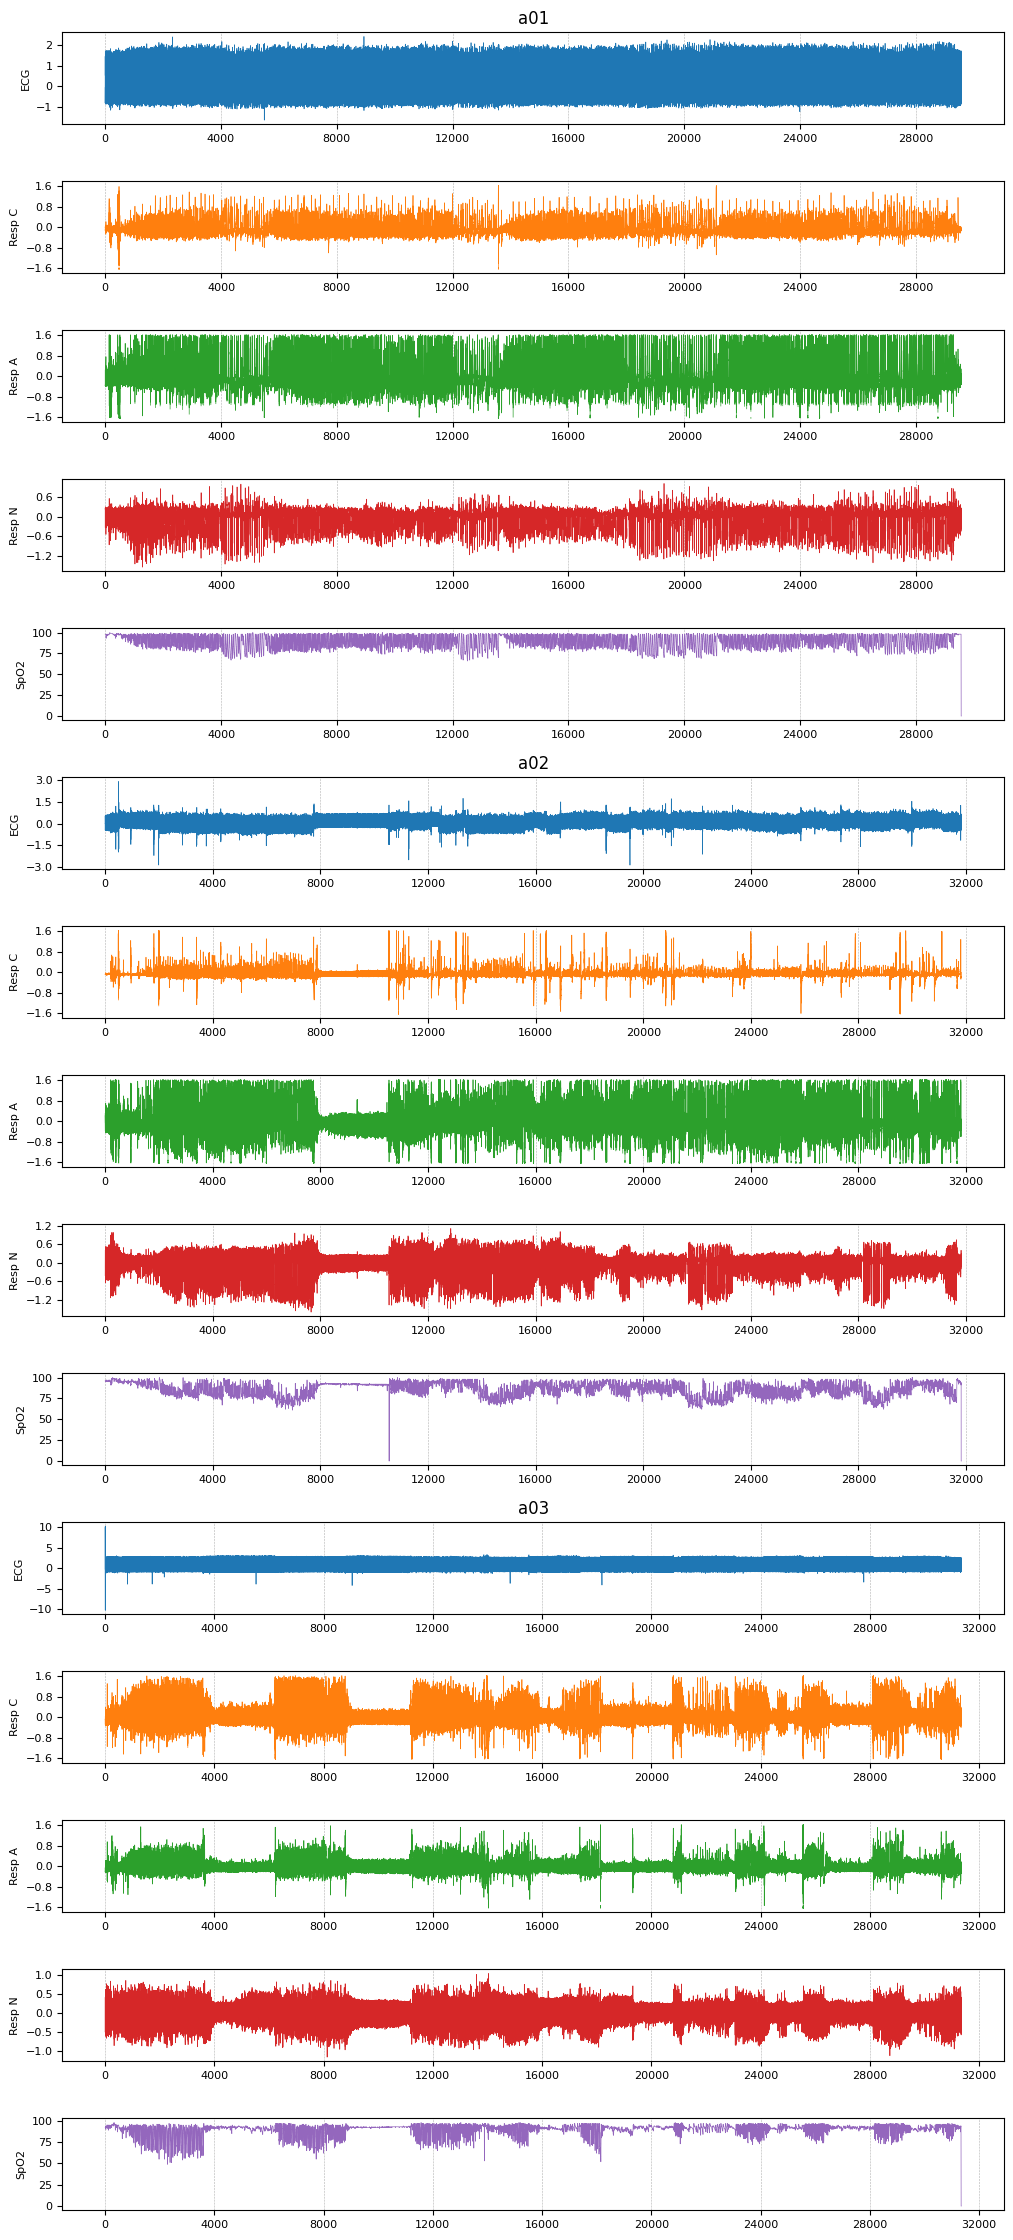

In [6]:
tp.plot([ecg_data, resp_data])

# Alternatively, individual event sets can also be plotted individually with:
#   ecg_data.plot()
#   resp_data.plot()

The range of the values look right. For example, SpO2 is expected to be between 0 and 100, and most of the time close to 100 for a patient in good health.
However, we cannot see much details. Let's simplify the plot by only printing the first 20 seconds of data for the first patient.

In addition, let's enable interactive plotting with `interactive=True`.

**Remarks:**
- Interactive plotting is not suited to print large amount of data like in the plot above. It will make the plot unresponsive.
- Temporian uses the Bokeh library for interactive plotting. Bokeh need to be separately with `pip install bokeh`.
- Try to zoom and pan in the interactive plots. Looking closely at the data is often interesting.

In [7]:
plot_args = {
    "min_time": 0,  # Start of the plotting time
    "max_time": 20,  # End of the plotting time
    "indexes": "a01",  # Only plot the data of the patient "a01"
    "interactive": True,  # Enable interactive plotting
}
tp.plot([ecg_data, resp_data], **plot_args)

On the ECG, you can see the heart rate. Each large up spike is a beat.
Right now, we have raw ECG data sampled at 100Hz, so there aez 100 events every seconds with the ECG value.
To compute heart rate, we need to detect the heat beats, so lets extract heat breat events i.e. an event each time there is an heart beat.

A heart beat is detected when two criteria are true:
- Criterion #1: The ecg value is in the above 70% of the moving range computed over the last 3 seconds.
- Criterion #2: There is at least 60/200=300ms (i.e. 200bpm) since the last detected heart beat.

**Note:** The moving range is the difference between the moving maximum and moving minimum.


In [8]:
ecg_node = ecg_data.node()

ecg = ecg_node["ECG"]

# === Begin of heart beat detection code ===

# Compute the moving min, max and range of the ECG
mmin = tp.moving_min(ecg, 3.0)
mmax = tp.moving_max(ecg, 3.0)
mrange = mmax - mmin

# TODO: Replace with "ecg > mmin + ecg_mrange * 0.7"
criterion_1_is_valid = ecg - (mmin + mrange * 0.7) > 0.0
# TODO: Make "filter" able to take an "events" without features as input (or a single argument)?
criterion_1_candidates = tp.filter(criterion_1_is_valid)
criterion_2_is_valid = tp.since_last(criterion_1_candidates) > 60.0 / 200

heart_beats = tp.rename(tp.filter(criterion_2_is_valid), "heart beat")
# === End of heart beat detection code ===

# Let' plot the raw ECG, criteron 1 and 2, and the heart beats.
to_plot = [
    ecg,
    tp.rename(criterion_1_is_valid, "criteria 1 is valid"),
    tp.rename(criterion_2_is_valid, "criteria 2 is valid"),
    heart_beats,
    # Add more intermediate results here to better understand the detection of heart beats.
]

tp.plot(tp.evaluate(to_plot, {ecg_node: ecg_data}), **plot_args)

From heart beats, we can compute the *heart rate* and *heart rate variability*, two important measure to monitor patient health.

The heart rate is the average heart beat frequency over the last 10 expressed in beats-per-minutes (bpm). It is computed by counting the number of beats in 60 seconds.

**Note:** The heart reate can also be computed by counting the number of beats in a shorter window (e.g. 20 seconds) and multiplying the number to get a number of beats per seconds.

In [9]:
heart_rate = tp.rename(tp.moving_count(heart_beats, 60.0), "heart rate")

to_plot = [
    heart_beats,
    heart_rate,
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
    interactive=True,
)

One way to compute the heart rate variability (HRV) is by using the standard deviation of the interval between successive heart beats (called RR interval) and expressed in ms.
We can compute it over 60s like for the heart beat or with a longer time windows for more stability (e.g., 240 seconds)

In [10]:
rr_interval = tp.since_last(heart_beats)

heart_rate_variability = tp.rename(
    tp.moving_standard_deviation(rr_interval, 240.0) * 1000.0,
    "heart rate variability",
)

to_plot = [
    heart_beats,
    heart_rate,
    heart_rate_variability,
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
    interactive=True,
)

Currently, heart rate and heart rate variability are calculated at every heartbeat, resulting in a large amount of non-uniform data. To enhance compatibility with other systems, a better approach would be to compute the heart rate at exact 10-second intervals instead. This approach will simplify the data analysis process and provide more consistent and uniform results.

The `tp.tick` function generates a uniform timestamp.
The `tp.resample` function sample a signal according to a secondary sampling.

**Note:** Window functions like tp.`moving_count` have an optional `sampling` argument which is equivalent, but currently more efficient than calling `tp.moving_count` and `tp.resample` separately. Our dataset is small enought that it does not matter.

In [11]:
# TODO: Replace with tick operator when implemented.
# uniform_sampling_10s = tp.tick(heart_rate, interval=10)
uniform_sampling_10s = tp.cast(tp.moving_count(ecg, 10000000.0), tp.int64)
uniform_sampling_10s = uniform_sampling_10s // 1000
uniform_sampling_10s = tp.equal(
    uniform_sampling_10s,
    tp.resample(tp.lag(uniform_sampling_10s, 0.01), uniform_sampling_10s) + 1,
)
uniform_sampling_10s = tp.filter(
    tp.select(uniform_sampling_10s, []), uniform_sampling_10s
)

heart_rate_every_10s = tp.rename(
    tp.resample(heart_rate, sampling=uniform_sampling_10s), "heart rate (10s)"
)
heart_rate_variability_every_10s = tp.rename(
    tp.resample(heart_rate_variability, sampling=uniform_sampling_10s),
    "heart rate variability (10s)",
)

to_plot = [
    uniform_sampling_10s,
    heart_beats,
    heart_rate,
    heart_rate_every_10s,
    heart_rate_variability,
    heart_rate_variability_every_10s,
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=500,
    max_time=560,
    indexes="a01",
    interactive=True,
)

Finally, let's apply our temporian processing on the whole record of all the patients

In [12]:
to_plot = [
    heart_rate_every_10s,
    heart_rate_variability_every_10s,
]

tp.plot(tp.evaluate(to_plot, {ecg_node: ecg_data}), interactive=True)

## Save Temporian program

Temporian preprocessing program can be exported to file to be re-loaded later.

In [13]:
tp.save(
    inputs={"ecg": ecg_node},
    outputs={
        "hb": heart_beats,
        "hr": heart_rate_every_10s,
        "hrv": heart_rate_variability_every_10s,
    },
    path="/tmp/heart_graph.tem",
)

An then, later, you can load and execute this preprocessing again.

loaded_inputs: dict_keys(['ecg'])
loaded_outputs: dict_keys(['hb', 'hr', 'hrv'])


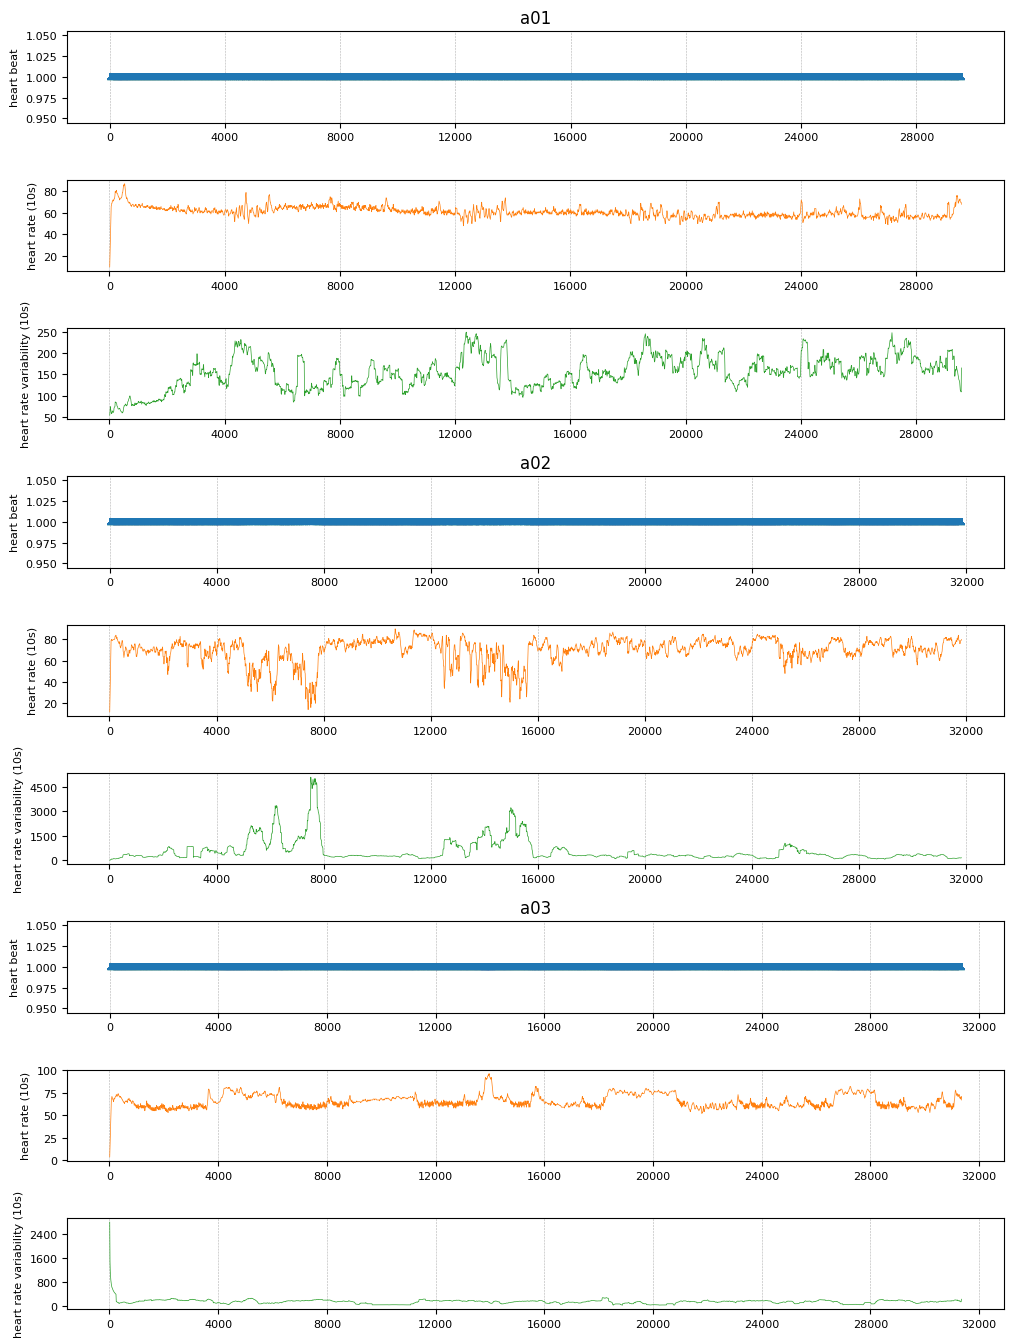

In [14]:
loaded_inputs, loaded_outputs = tp.load(path="/tmp/heart_graph.tem")
print("loaded_inputs:", loaded_inputs.keys())
print("loaded_outputs:", loaded_outputs.keys())

tp.plot(
    tp.evaluate(
        [loaded_outputs["hb"], loaded_outputs["hr"], loaded_outputs["hrv"]],
        {loaded_inputs["ecg"]: ecg_data},
    )
)

# Or, equivalently:
# tp.plot(tp.evaluate(
#         loaded_outputs,
#         {loaded_inputs["ecg"]: ecg_data})
# )

## Homework

At the beginning of a recording, it may take some time to detect enough beats for an accurate heart rate reading. Update the definition of `heart_rate_every_10s` such that it does not compute the heart beat during the first minute of the record.

**Help:**
- The `tp.begin(x)` function create a single event at the beginning of the record for each index value of `x`.
- `tp.since_last(event=tp.begin(x), sampling=x)` is the time since the start of the record for each timestamp of `x`.

In [15]:
## Solution

# TODO: Reaplce with "begin" operator when available
# begin = tp.begin(heart_rate)
begin = tp.cast(tp.moving_count(ecg, 10.0), tp.int64)
begin = tp.equal_scalar(begin, 1)
begin = tp.filter(begin)

more_than_60s_since_begin = tp.since_last(begin, heart_rate_every_10s) > 60.0
improved_heart_rate = tp.rename(
    tp.filter(heart_rate_every_10s, more_than_60s_since_begin),
    "improved_heart_rate",
)

to_plot = [
    heart_rate_every_10s,
    improved_heart_rate,
]

tp.plot(
    tp.evaluate(to_plot, {ecg_node: ecg_data}),
    min_time=0,
    max_time=60 * 5,
    indexes="a01",
    interactive=True,
)